In [469]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 999

import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.updates import adam
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [147]:
%matplotlib notebook

In [20]:
grbz_data_sr = pd.read_pickle('data/grbz_data.pkl.gz', compression='gzip')

In [21]:
final_df = grbz_data_sr['grbz_clean_final']

In [105]:
selected_columns = [
#     'GRB',
#     'UTC_Time',
#     'BAT_RA',
#     'BAT_Dec',
#     'BAT_Error_Radius',
#     'BAT_T90_lo',
#     'BAT_T90_hi',
#     'BAT_Fluence',
#     'BAT_Fluence_Error',
#     'BAT_Peak_Photon_Flux',
#     'BAT_Peak_Photon_Flux_Error',
#     'BAT_Photon_Index',
    'BAT_Photon_Index_Model_Index',
#     'BAT_Photon_Index_Error_Min',
#     'BAT_Photon_Index_Error_Max',
#     'XRT_RA',
#     'XRT_Dec',
#     'XRT_Error_Radius',
#     'XRT_Time_to_First_Observation',
    'XRT_Early_Flux',
#     'XRT_11_Hour_Flux',
#     'XRT_24_Hour_Flux',
#     'XRT_Initial_Temporal_Index',
    'XRT_Spectral_Index_Gamma',
    'XRT_Column_Density_NH',
#     'UVOT_RA',
#     'UVOT_Dec',
#     'UVOT_Error_Radius',
#     'UVOT_Time_to_First_Observation',
    'UVOT_V_lo',
    'UVOT_V_hi',
    'UVOT_B_lo',
    'UVOT_B_hi',
#     'UVOT_U_lo',
#     'UVOT_U_hi',
#     'UVOT_UVW1_lo',
#     'UVOT_UVW1_hi',
#     'UVOT_UVM2_lo',
#     'UVOT_UVM2_hi',
    'UVOT_UVW2_lo',
    'UVOT_UVW2_hi',
    'UVOT_White_lo',
    'UVOT_White_hi',
#     'UVOT_White_FC_lo',
#     'UVOT_White_FC_hi',
#     'UVOT_U_FC_lo',
#     'UVOT_U_FC_hi',
    'Redshift',
    'Redshift_Error'
]

In [106]:
selection_df = final_df[selected_columns]

# Handling missing data points
## Mean method
The mean method is the worst possible method of handling missing data in training sets, but it might be interesting to compare with later results.

In [111]:
selection_df = selection_df[~selection_df['BAT_Photon_Index_Model_Index'].isna()]

In [114]:
selection_df = selection_df[selection_df['Redshift_Error']<0.5]

In [115]:
train_df = selection_df.where(~selection_df.isna(), selection_df.mean(axis=0), axis=1)

In [183]:
test_selection = np.random.permutation(len(train_df))[:int(len(train_df)/10)]

In [202]:
test_df = train_df.iloc[test_selection]

In [191]:
test_selection

array([ 47, 259, 155, 139, 195, 100, 242, 196, 251, 257, 159, 201, 237,
        96,  10,   6,  78, 157,  17,  23,  87, 134, 324,  45,   2,  91,
       219,  50, 228, 149,  81, 132, 347, 274, 136])

In [205]:
train_df = train_df.drop(train_df.index[test_selection],axis=0)

In [206]:
train_X = train_df.drop(['Redshift','Redshift_Error'], axis=1).values.astype(np.float32)
test_X = test_df.drop(['Redshift','Redshift_Error'], axis=1).values.astype(np.float32)

In [122]:
train_X.shape

(351, 12)

In [457]:
z_threshold = 1.7

In [458]:
train_y = (train_df['Redshift'].values > z_threshold).astype(np.int8)
test_y = (test_df['Redshift'].values > z_threshold).astype(np.int8)

In [527]:
mean1_net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('dense1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        ('dense2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        ('output', layers.DenseLayer),
    ],
    # input layer
    input_shape = (None, train_X.shape[1]),
    # dense1
    dense1_num_units = 128,
    dense1_nonlinearity = lasagne.nonlinearities.leaky_rectify,
    # dropout1
    dropout1_p = 0.5,
    # dense2
    dense2_num_units = 128,
    dense2_nonlinearity = lasagne.nonlinearities.leaky_rectify,
    # dropout2
    dropout2_p = 0.5,
    # output
    output_nonlinearity = lasagne.nonlinearities.softmax,
    output_num_units = 2,
    # optimization method params
    # original config in comments
    batch_iterator_test=BatchIterator(batch_size=train_X.shape[0],shuffle=False),
    batch_iterator_train=BatchIterator(batch_size=train_X.shape[0],shuffle=False),
    train_split=TrainSplit(eval_size=0.1),
    objective_loss_function = lasagne.objectives.multiclass_hinge_loss,
    objective_l2 = 0.001,
    update=adam, # nesterov_momentum,
    update_learning_rate = 0.002, # 0.01,
    # Adam doesn't need update_momentum
    # update_momentum=0.9,
    max_epochs = 4,
    verbose = 1,
    )

In [528]:
mean1_nn = mean1_net.fit(train_X,train_y)

# Neural Network with 18434 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input         12
  1  dense1       128
  2  dropout1     128
  3  dense2       128
  4  dropout2     128
  5  output         2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.12088     1.14974    0.97490      0.50000  0.01s
      2     1.14599     1.14734    0.99882      0.50000  0.01s
      3     1.15924     1.14517    1.01229      0.50000  0.01s
      4     1.12591     1.14306    0.98499      0.50000  0.01s


In [529]:
def get_history(nnet):
    history = nnet.train_history_
    T = len(history)
    epochs = np.zeros(T)
    durs = np.zeros(T)
    tr_loss = np.zeros(T)
    va_loss = np.zeros(T)
    va_acc = np.zeros(T)
    for k in range(T):
        epochs[k] = history[k]['epoch']
        durs[k] = history[k]['dur']
        tr_loss[k] = history[k]['train_loss']
        va_loss[k] = history[k]['valid_loss']
        va_acc[k] = history[k]['valid_accuracy']
    
    return va_loss, tr_loss, va_acc, durs, epochs

In [530]:
mean1_va_loss, mean1_tr_loss, mean1_va_acc, mean1_durs, mean1_epochs = get_history(mean1_net)

In [531]:
mean1_tr_loss

array([1.12088203, 1.14599133, 1.1592437 , 1.1259079 ])

<IPython.core.display.Javascript object>


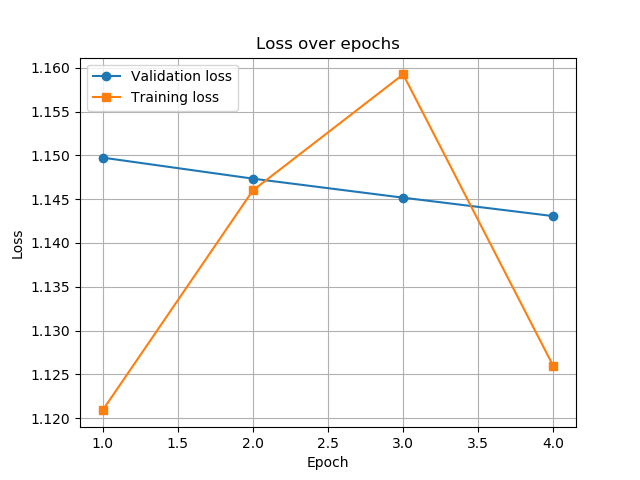

In [532]:
mean1_fig, mean1_axes = plt.subplots(num='Mean Method (1) Loss Function')
mean1_axes.plot(mean1_epochs,mean1_va_loss,'o-')
mean1_axes.plot(mean1_epochs,mean1_tr_loss,'s-')
mean1_axes.set_ylabel("Loss")
mean1_axes.set_title("Loss over epochs")
mean1_axes.set_xlabel("Epoch")
mean1_axes.legend(["Validation loss","Training loss"])
mean1_axes.grid()
mean1_fig.show()

In [533]:
# Predict test dataset
mean1_preds = mean1_net.predict(test_X)

In [534]:
# Compiling into theano function
mean1_input_var = mean1_net.layers_['input'].input_var
mean1_output_layer = layers.get_output(mean1_net.layers_['output'], deterministic=True)
mean1_output_f = theano.function([mean1_input_var], mean1_output_layer)

In [535]:
np.argmax(mean1_output_f(test_X),axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

<IPython.core.display.Javascript object>


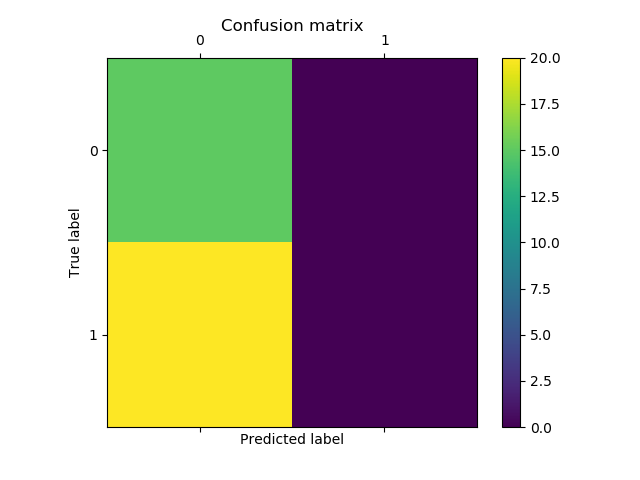

In [536]:
mean1_confmat = confusion_matrix(test_y, mean1_preds)

mean1_confmat_fig, mean1_confmat_axes = plt.subplots(num='Mean Method Confusion Matrix (1)')

mean1_confmat_img = mean1_confmat_axes.matshow(mean1_confmat)
mean1_confmat_axes.set_title('Confusion matrix')
mean1_confmat_fig.colorbar(mean1_confmat_img)
mean1_confmat_axes.set_ylabel('True label')
mean1_confmat_axes.set_xlabel('Predicted label')
mean1_confmat_fig.show()

<IPython.core.display.Javascript object>


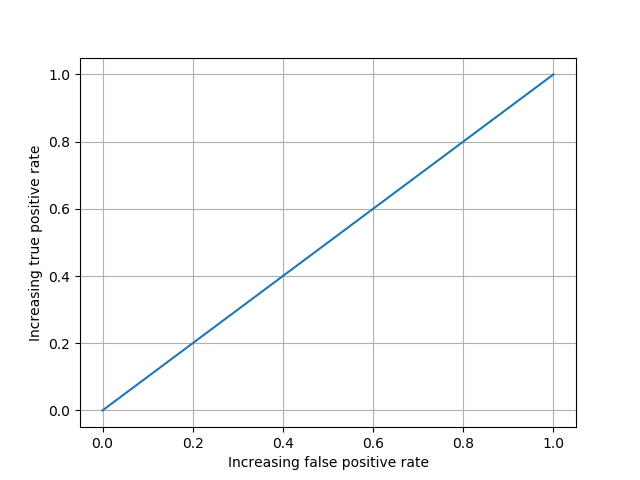

In [537]:
fpr, tpr, thrs = roc_curve(test_y, mean1_preds)

mean1_roc_fig, mean1_roc_axes = plt.subplots(num='Mean Method  Receiver operating characteristic (1)')
mean1_roc_axes.plot(fpr, tpr)
mean1_roc_axes.set_xlabel('Increasing false positive rate')
mean1_roc_axes.set_ylabel('Increasing true positive rate')
mean1_roc_axes.grid()
mean1_roc_fig.show()